In [1]:
import fitsio as ft
import numpy as np
from glob import glob
from astropy.table import Table, vstack, hstack
from scipy.interpolate import interp1d
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import modules as ms
import healpy as hp

In [2]:

def hpixsum(nside, ra, dec, weights=None):
    hpix = radec2hpix(nside, ra, dec)
    npix = hp.nside2npix(nside)
    weight_hp = np.bincount(hpix, weights=weights, minlength=npix)
    return weight_hp


def radec2hpix(nside, ra, dec):
    hpix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
    return hpix


def radec2pos(ra, dec):
    """ converting ra dec to position on a unit sphere.
        ra, dec are in degrees.
    """
    pos = np.empty(len(ra), dtype=('f8', 3))
    ra = ra * (np.pi / 180)
    dec = dec * (np.pi / 180)
    pos[:, 2] = np.sin(dec)
    pos[:, 0] = np.cos(dec) * np.sin(ra)
    pos[:, 1] = np.cos(dec) * np.cos(ra)
    return pos

def veto(coord, center, R):
    """
        Returns a veto mask for coord. any coordinate within R of center
        is vet.
        Parameters
        ----------
        coord : (RA, DEC)
        center : (RA, DEC)
        R     : degrees
        Returns
        -------
        Vetomask : True for veto, False for keep.
    """
    pos_stars = radec2pos(center[0], center[1])
    R = 2 * np.sin(np.radians(R) * 0.5)
    pos_obj = radec2pos(coord[0], coord[1])
    tree = KDTree(pos_obj)
    vetoflag = np.zeros(len(pos_obj), dtype='?')
    arg = tree.query_radius(pos_stars, r=R)
    arg = np.concatenate(arg)
    vetoflag[arg] = True
    return vetoflag

In [3]:
ls /fs/ess/PHS0336/data/randoms/

randoms-1-0.fits   randoms-1-15.fits  randoms-1-2.fits  randoms-1-8.fits
randoms-1-10.fits  randoms-1-16.fits  randoms-1-3.fits  randoms-1-9.fits
randoms-1-11.fits  randoms-1-17.fits  randoms-1-4.fits  randoms-allsky/
randoms-1-12.fits  randoms-1-18.fits  randoms-1-5.fits
randoms-1-13.fits  randoms-1-19.fits  randoms-1-6.fits
randoms-1-14.fits  randoms-1-1.fits   randoms-1-7.fits


In [4]:
ls /fs/ess/PHS0336/data/randoms/randoms-allsky/

randoms-allsky-1-0.fits   randoms-allsky-1-14.fits  randoms-allsky-1-7.fits
randoms-allsky-1-12.fits  randoms-allsky-1-17.fits


In [5]:
loader =  ms.DataLoader(maskbits=[1, 12, 13])

data_dir            : /fs/ess/PHS0336/data/elgmask
gaia_path           : /fs/ess/PHS0336/data/elgmask/gaia_lrg_mask_v1.fits
gaia_suppl_path     : /fs/ess/PHS0336/data/elgmask/gaia_reference_suppl_dr9.fits
gaia_columns        : ['RA', 'DEC', 'mask_mag']
target_class        : ELG
maskbits            : [1, 12, 13]
min_nobs            : 1



In [6]:
def project_randoms(photsys):
    field='north' if photsys=='N' else 'south'
    maskbits = [1, 12, 13]
    min_nobs = 1    
    randoms_columns = ['RA', 'DEC', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'PHOTSYS', 'MASKBITS']
    randoms_paths = ['/fs/ess/PHS0336/data/randoms/randoms-1-12.fits', 
                     '/fs/ess/PHS0336/data/randoms/randoms-1-0.fits',
                     '/fs/ess/PHS0336/data/randoms/randoms-1-14.fits',
                     '/fs/ess/PHS0336/data/randoms/randoms-1-7.fits',
                      '/fs/ess/PHS0336/data/randoms/randoms-1-17.fits']
    print('len of files', len(randoms_paths))

    randoms_density = ft.read_header(randoms_paths[0], ext=1)['DENSITY']  # randoms per sq. deg.
    print(randoms_density)

    randoms_stack = []
    for randoms_path in randoms_paths:
        print(randoms_path)
        randoms = Table(ft.read(randoms_path, columns=randoms_columns))
        randoms_stack.append(randoms)
    randoms = vstack(randoms_stack)

    mask = (randoms['PHOTSYS']==photsys)
    randoms = randoms[mask]

    mask = (randoms['NOBS_G']>=min_nobs) & (randoms['NOBS_R']>=min_nobs) & (randoms['NOBS_Z']>=min_nobs)
    randoms = randoms[mask]

    # Apply masks
    randoms_clean = np.ones(len(randoms), dtype=bool)
    for bit in maskbits:
        randoms_clean &= (randoms['MASKBITS'] & 2**bit)==0
    randoms = randoms[randoms_clean]

    # Remove pixels near the LMC
    ramin, ramax, decmin, decmax = 58, 110, -90, -56
    mask_remove = (randoms['RA']>ramin) & (randoms['RA']<ramax) & (randoms['DEC']>decmin) & (randoms['DEC']<decmax)

    print('randoms:', len(randoms))
    randoms = randoms[~mask_remove]
    print('randoms:', len(randoms))

    gaia = loader.read_gaia(field)       # read gaia star catalog

    radius_deg = gaia['radius'].data / 3600 # deg
    center = (gaia['RA'].data, gaia['DEC'].data)
    coordr = (randoms['RA'].data, randoms['DEC'].data)
    is_badr = veto(coordr, center, radius_deg)

    siena = loader.read_siena(field)       # read siena gal catalog
    siena_mag_list = np.array([7.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5])
    radii = [700., 400., 300., 250., 200., 125., 100.]
    radii_int = interp1d(siena_mag_list[:-1], radii, bounds_error=False, fill_value='extrapolate')
    is_good = siena['MAG_LEDA'] < 15.5
    siena = siena[is_good]
    siena['radius_mag'] = radii_int(siena['MAG_LEDA'])

    radius_deg = siena['radius_mag'].data / 3600 # deg
    center = (siena['RA'].data, siena['DEC'].data)
    is_badr_siena = veto(coordr, center, radius_deg)

    is_badr_tot = is_badr | is_badr_siena

    del gaia
    del siena
    del coordr

    randoms = randoms[~is_badr_tot]
    wmap = hpixsum(1024, randoms['RA'], randoms['DEC'])*1.
    hp.write_map(f'/fs/ess/PHS0336/data/elgmask/randoms_{field}_hp_1024.fits', wmap, fits_IDL=False)
    hp.mollview(wmap)

In [24]:
randoms_columns = ['RA', 'DEC', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'PHOTSYS', 'MASKBITS']
randoms_paths = ['/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-12.fits', 
                 '/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-0.fits',
                 '/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-14.fits',
                 '/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-7.fits',
                  '/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-17.fits']
print('len of files', len(randoms_paths))

randoms_density = ft.read_header(randoms_paths[0], ext=1)['DENSITY']  # randoms per sq. deg.
print(randoms_density)

randoms_stack = []
for randoms_path in randoms_paths:
    print(randoms_path)
    randoms = Table(ft.read(randoms_path, columns=randoms_columns))
    randoms_stack.append(randoms)
randoms = vstack(randoms_stack)
wmap_allsky = hpixsum(1024, randoms['RA'], randoms['DEC'])*1.
hp.write_map('/fs/ess/PHS0336/data/elgmask/randoms_allsky_hp_1024.fits', wmap_allsky, fits_IDL=False)

len of files 5
2500
/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-12.fits
/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-0.fits
/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-14.fits
/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-7.fits
/fs/ess/PHS0336/data/randoms/randoms-allsky/randoms-allsky-1-17.fits


len of files 5
2500
/fs/ess/PHS0336/data/randoms/randoms-1-12.fits
/fs/ess/PHS0336/data/randoms/randoms-1-0.fits
/fs/ess/PHS0336/data/randoms/randoms-1-14.fits
/fs/ess/PHS0336/data/randoms/randoms-1-7.fits
/fs/ess/PHS0336/data/randoms/randoms-1-17.fits
randoms: 62660364
randoms: 62660364
# of gaia objects: 41065340
# of gaia objects (north): 10862797
# of Siena objects: 383620
# of gaia objects (north): 104237


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


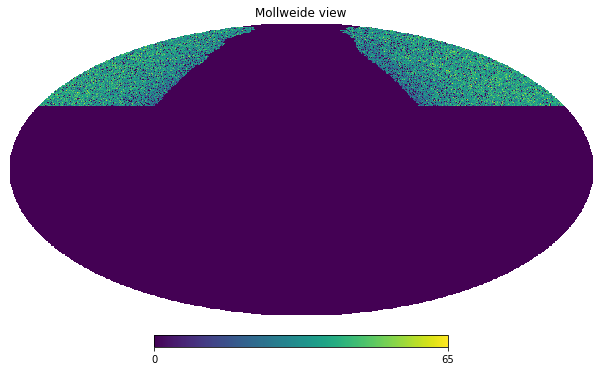

In [8]:
project_randoms('N')

In [9]:
ls /fs/ess/PHS0336/data/elgmask/

dr9_elg_north_1.0.0_basic.fits  randoms_allsky_hp_1024.fits
dr9_elg_south_1.0.0_basic.fits  randoms_for_elgs.fits
elgmask.tar                     randoms_north_hp_1024.fits
gaia_lrg_mask_v1.fits           randoms_south_hp_1024.fits
gaia_reference_suppl_dr9.fits


In [10]:
random_north = hp.read_map('/fs/ess/PHS0336/data/elgmask/randoms_north_hp_1024.fits')
random_south = hp.read_map('/fs/ess/PHS0336/data/elgmask/randoms_south_hp_1024.fits')
random_all = hp.read_map('/fs/ess/PHS0336/data/elgmask/randoms_allsky_hp_1024.fits')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [11]:
random = random_north + random_south

In [12]:
frac = random / random_all

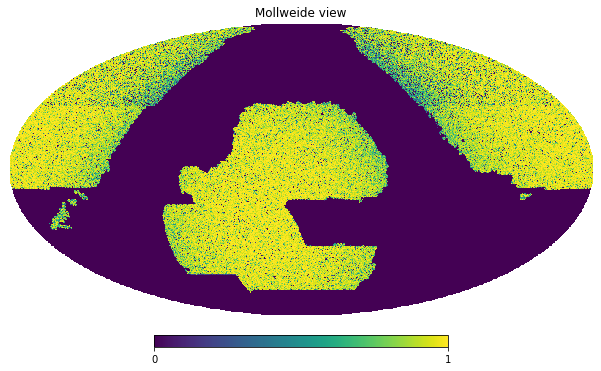

In [13]:
hp.mollview(frac)

In [15]:
hp.write_map('/fs/ess/PHS0336/data/elgmask/fracgood_hp_1024.fits', frac, fits_IDL=False)

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(
